In [ ]:
import pandas as pd
import numpy as np
import random
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn. naive_bayes import BernoulliNB
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

In [ ]:
import nltk
from wordcloud import WordCloud

## Get the Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
characters = pd.read_csv('/content/drive/Shareddrives/IRTM/data/simpsons_characters.csv')
characters.head()

,id,name,normalized_name,gender
0,7,Children,children,NaN
1,12,Mechanical Santa,mechanical santa,NaN
2,13,Tattoo Man,tattoo man,NaN
3,16,DOCTOR ZITSOFSKY,doctor zitsofsky,NaN
4,20,Students,students,NaN


In [ ]:
script_lines = pd.read_csv('/content/drive/Shareddrives/IRTM/data/simpsons_script_lines.csv')
script_lines.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (4,5,6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,episode_id,number,raw_text,timestamp_in_ms,speaking_line,character_id,location_id,raw_character_text,raw_location_text,spoken_words,normalized_text,word_count
0,9549,32,209,"Miss Hoover: No, actually, it was a little of ...",848000,True,464,3.0,Miss Hoover,Springfield Elementary School,"No, actually, it was a little of both. Sometim...",no actually it was a little of both sometimes ...,31
1,9550,32,210,Lisa Simpson: (NEAR TEARS) Where's Mr. Bergstrom?,856000,True,9,3.0,Lisa Simpson,Springfield Elementary School,Where's Mr. Bergstrom?,wheres mr bergstrom,3
2,9551,32,211,Miss Hoover: I don't know. Although I'd sure l...,856000,True,464,3.0,Miss Hoover,Springfield Elementary School,I don't know. Although I'd sure like to talk t...,i dont know although id sure like to talk to h...,22
3,9552,32,212,Lisa Simpson: That life is worth living.,864000,True,9,3.0,Lisa Simpson,Springfield Elementary School,That life is worth living.,that life is worth living,5
4,9553,32,213,Edna Krabappel-Flanders: The polls will be ope...,864000,True,40,3.0,Edna Krabappel-Flanders,Springfield Elementary School,The polls will be open from now until the end ...,the polls will be open from now until the end ...,33




```
# 此內容會顯示為程式碼
```

## Text Preprocessing


In [ ]:
data = script_lines[['spoken_words', 'character_id', 'location_id']]
data = data.dropna()
data = data.reset_index(drop=True)

data['character_id'] = [ int(x) for x in data['character_id']]

In [ ]:
target_char_id= [2, 1, 8, 9, 15, 17, 3, 11, 31, 71, 25, 139, 101, 165]

In [ ]:
# target_data = data[data['character_id'].isin(target_char_id)]
# target_data = target_data.reset_index(drop=True)

In [ ]:
target_char_id_less= [15, 17, 3, 11, 31, 71, 25, 139, 101, 165]
target_data = data[data['character_id'].isin(target_char_id_less)]

from sklearn.utils import shuffle
temp_2 = shuffle(data[data['character_id'] == 2], random_state=0).reset_index(drop=True)
temp_1 = shuffle(data[data['character_id'] == 1], random_state=0).reset_index(drop=True)
temp_8 = shuffle(data[data['character_id'] == 8], random_state=0).reset_index(drop=True)
temp_9 = shuffle(data[data['character_id'] == 9], random_state=0).reset_index(drop=True)

target_data = pd.concat([temp_2[:3500], temp_1[:3500], temp_8[:3500], temp_9[:3500], target_data], axis=0)
target_data = target_data.reset_index(drop=True)



In [ ]:
target_data

,spoken_words,character_id,location_id
0,"Knock 'em dead, boy! Kid's gonna be a black be...",2,8.0
1,"Oh, sit tight. I'll be right back.",2,51.0
2,"Yes, sir.",2,3893.0
3,"Well, it is a good life, believe me... All rig...",2,5.0
4,"Oh sure, when a man does it, it's smutty. But ...",2,5.0
...,...,...,...
33816,"No children, your not seeing things, this, my ...",3,3.0
33817,Are you the substitute?,3,3.0
33818,Are you insane?,3,3.0
33819,"Well, all right. Play friendly with your new t...",3,3.0


In [ ]:
for c in target_char_id:
  print(c)
  print(len(target_data[target_data["character_id"]==c]))


2
3500
1
3500
8
3500
9
3500
15
3121
17
2808
3
2387
11
2054
31
1870
71
1796
25
1795
139
1702
101
1145
165
1143


In [ ]:
from wordcloud import STOPWORDS
for c in target_char_id:
  temp = target_data[target_data["character_id"]==c]["spoken_words"].tolist()
  temp_string = ''.join(str(e) for e in temp)
  name = characters[characters["id"]==c]['name'].tolist()[0]
  
  print(c,name)
  cloud = WordCloud(background_color="white",max_words=30,stopwords = set(STOPWORDS))
  cloud.generate(temp_string)
  #plt.imshow(cloud)
  cloud.to_file("/content/drive/Shareddrives/IRTM/word cloud/ W "+str(c)+' '+ name+'.png')


2 Homer Simpson
1 Marge Simpson
8 Bart Simpson
9 Lisa Simpson
15 C. Montgomery Burns
17 Moe Szyslak
3 Seymour Skinner
11 Ned Flanders
31 Grampa Simpson
71 Chief Wiggum
25 Milhouse Van Houten
139 Krusty the Clown
101 Nelson Muntz
165 Lenny Leonard


## Turn Documents into TF-IDF Vectors


In [ ]:
Document = []
Names = []
for c in target_char_id:
  temp = target_data[target_data["character_id"]==c]["spoken_words"].tolist()
  temp_string = ''.join(str(e) for e in temp)
  
  Document.append(temp_string)

  name = characters[characters["id"]==c]['name'].tolist()[0]
  Names.append([c,name])
  
  print(c,name)

2 Homer Simpson
1 Marge Simpson
8 Bart Simpson
9 Lisa Simpson
15 C. Montgomery Burns
17 Moe Szyslak
3 Seymour Skinner
11 Ned Flanders
31 Grampa Simpson
71 Chief Wiggum
25 Milhouse Van Houten
139 Krusty the Clown
101 Nelson Muntz
165 Lenny Leonard


In [ ]:
TFIDF_vectorizer = TfidfVectorizer(lowercase=True, stop_words='english')
TFIDF_vectors = TFIDF_vectorizer.fit_transform(Document)

In [ ]:
feature_names = TFIDF_vectorizer.get_feature_names()
corpus_index = [n for n in Document]

# create pandas DataFrame with tf-idf scores: Term-Document Matrix
df_tf_idf = pd.DataFrame(TFIDF_vectors .T.todense(), index = feature_names, columns = target_char_id)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
df_tf_idf.iloc[:,0].nlargest(n=10)

In [ ]:
for i in range(14):
  c = Names[i][0]
  name = Names[i][1] 
  print(Names[i])
  print(df_tf_idf.iloc[:,i].nlargest(n=10))
  Cloud = WordCloud(background_color="white",max_words=30).generate_from_frequencies(df_tf_idf.iloc[:,i])
  Cloud.to_file("/content/drive/Shareddrives/IRTM/word cloud/tfidf W "+str(c)+' '+ name+'.png')



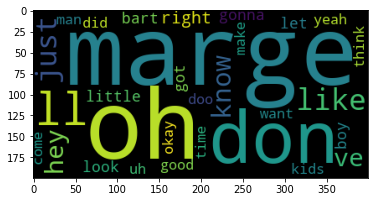

In [ ]:
Cloud = WordCloud(max_words=30).generate_from_frequencies(df_tf_idf.iloc[:,0])
plt.imshow(Cloud)